In [459]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import pandas_datareader as web
import datetime as dt

In [460]:
amazon_df = pd.read_csv('AMZN_Daily_10year.csv')

In [461]:
def load_data(df, start, end):
    """
    Load data for the date range.

    :param start: The starting date for the data range (str or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return: A dataframe containing the relevant stock data (pandas.DataFrame)
    """
    dataframe = df.copy()
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    return dataframe

In [462]:
START_DATE = dt.datetime(2013,11,1)
END_DATE = dt.datetime(2021,11,1)

START_DATE_TEST = END_DATE

In [463]:
# Convert 'Date' to datetime format

amazon_df['Date'] = pd.to_datetime(amazon_df['Date'])

In [464]:
# Load the training data and scale the data.
# combined the scaled data into one array with dim [2012, 1]
# Also prepare the test inputs

# Set the number of days used for prediction
prediction_days = 120

#prepare training data
train_data = load_data(amazon_df,
                 start = START_DATE,
                 end = END_DATE)

scaler = MinMaxScaler() # default [0,1]
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

# prepare the test data
test_data = load_data(amazon_df,
start=START_DATE_TEST,
end=dt.datetime.now()
)

actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [465]:
# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# Think of this as a list of 2D arrays it should have dimensions (1977,35,1)

# Build the Model

In [466]:
regressor = RandomForestRegressor(n_estimators = 100)
regressor.fit(x_train, y_train)



RandomForestRegressor()

In [467]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = regressor.predict(x_test)
predicted_prices = predicted_prices.reshape(-1, 1)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

In [468]:
#test_predict = predicted_prices.reshape(-1,1)
print("Test data prediction:", predicted_prices.shape)

Test data prediction: (503, 1)


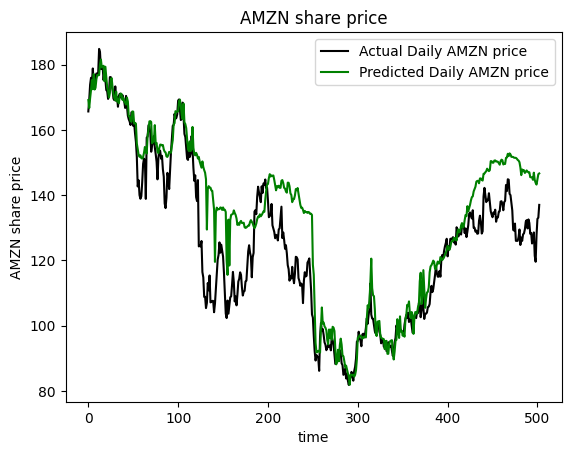

In [469]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual Daily AMZN price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted Daily AMZN price")

# Set the title of the plot using the company name
plt.title(f"AMZN share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"AMZN share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [470]:
# RMSE
# Step 1: Calculate the squared differences
squared_diff = (predicted_prices.flatten() - actual_prices) ** 2

# Step 2: Compute the mean of squared differences
mean_squared_diff = squared_diff.mean()

# Step 3: Take the square root to get RMSE
rmse = np.sqrt(mean_squared_diff)

print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 12.560083211074216


In [471]:
trials = [12.363, 12.479, 12.511, 12.769, 12.428, 12.619, 12.111, 12.261, 12.453, 12.501,
          12.525, 12.772, 12.586, 13.202, 12.289, 12.045, 12.647, 13.013, 11.856, 13.042]

In [472]:
sum(trials) / len(trials)

12.523599999999998

Average RMSE = 12.524